<a href="https://colab.research.google.com/github/inderpreetsingh01/PyTorch/blob/main/D2l_3_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
https://audreywongkg.medium.com/pytorch-nn-parameter-vs-nn-linear-2131e319e463

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F

In [ ]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

In [ ]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[list(range(len(y_hat))), y]).mean()

In [ ]:
loss = cross_entropy(y_hat, y)
loss

tensor(1.4979)

In [ ]:
# pytorch implement softmax in this way to avoid overflow from exponential
def softmax_torch(logits): # Assuming x has atleast 2 dimensions
    logits_exp = torch.exp(logits-torch.max(logits, 1, keepdim=True)[0])
    probs = logits_exp/torch.sum(logits_exp, 1, keepdim=True)
    return probs

In [ ]:
logits = torch.randn((4, 3))
probs = softmax_torch(logits)

In [ ]:
logits

tensor([[ 0.6500,  0.3703,  2.0056],
        [ 0.2045,  1.1772,  0.2339],
        [-1.3585, -1.2477, -0.8664],
        [-0.8719,  2.7817,  0.1238]])

In [ ]:
probs

tensor([[0.1775, 0.1342, 0.6884],
        [0.2139, 0.5658, 0.2203],
        [0.2665, 0.2977, 0.4359],
        [0.0236, 0.9124, 0.0640]])

In [9]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.sigmoid(x)
y.backward(torch.ones_like(x))

In [4]:
import matplotlib.pyplot as plt

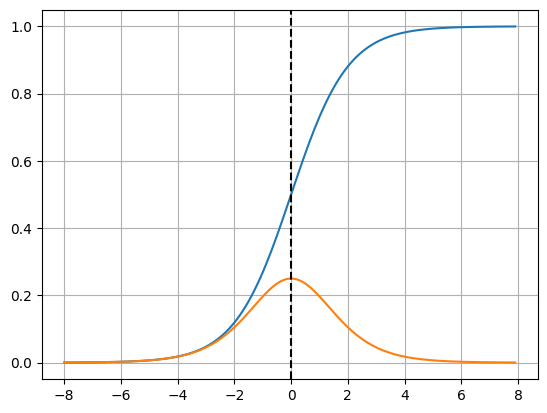

In [17]:
plt.plot(x.detach().numpy(), y.detach().numpy())
plt.plot(x.detach().numpy(), x.grad.numpy())
plt.axvline(x=0, linestyle='--', color='k')
plt.grid(True)

In [20]:
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    if dropout == 1: return torch.zeros_like(X)
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)

In [21]:
t = torch.tensor(list(range(10)))
out = dropout_layer(t, dropout=0.5)
print('out', out)

out tensor([ 0.,  0.,  4.,  6.,  8.,  0., 12., 14.,  0., 18.])


In [22]:
torch.sum(out)

tensor(62.)

In [23]:
torch.sum(t)

tensor(45)

In [30]:
mask = (torch.rand(t.shape)>0.5).float()
(mask*t)/(1-0.5)

tensor([ 0.,  0.,  0.,  6.,  8., 10., 12.,  0.,  0., 18.])

In [26]:
# Custom Models

In [5]:
class MySequential(nn.Module):
    def __init__(self, *args):
        super().__init__()
        for idx, module in enumerate(args):
            self.add_module(str(idx), module)

    def forward(self, X):
        for module in self.children():
            X = module(X)
        return X

In [8]:
net = MySequential(nn.LazyLinear(256), nn.ReLU(), nn.LazyLinear(10))

In [7]:
X = torch.rand(2, 20)
net(X).shape

torch.Size([2, 10])

In [9]:
# Implementing a linear layer with fixed weights
class FixedHiddenMLP(nn.Module):
    def __init__(self):
        super().__init__()
        # Random weight parameters that will not compute gradients and
        # therefore keep constant during training
        self.rand_weight = torch.rand((20, 20))
        self.linear = nn.LazyLinear(20)

    def forward(self, X):
        X = self.linear(X)
        X = F.relu(X @ self.rand_weight + 1)
        # Reuse the fully connected layer. This is equivalent to sharing
        # parameters with two fully connected layers
        X = self.linear(X)
        # Control flow
        while X.abs().sum() > 1:
            X /= 2
        return X.sum()

In [12]:
model = FixedHiddenMLP()
model(X)

tensor(-0.1074, grad_fn=<SumBackward0>)

In [17]:
class CustomLayer(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(10, 20)
    self.linear2 = nn.Linear(20, 1)
    self.constant = torch.tensor([0.3])

  def forward(self, X):
    X = self.linear1(X)
    X = self.linear2(X)
    X = F.relu(X @ self.constant + 1)
    if X>0:
      return X
    else:
      return -1

In [18]:
layer = CustomLayer()
layer(torch.randn(10))

tensor(1.1591, grad_fn=<ReluBackward0>)

In [ ]:
# Parameter Management

In [19]:
net = nn.Sequential(nn.LazyLinear(8),
                    nn.ReLU(),
                    nn.LazyLinear(1))

X = torch.rand(size=(2, 4))
net(X).shape

torch.Size([2, 1])

In [24]:
net.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.1647, -0.0029,  0.0944,  0.0961],
                      [ 0.0093,  0.1787,  0.4110, -0.3637],
                      [ 0.4098, -0.0703,  0.2340, -0.2936],
                      [ 0.3628, -0.0185, -0.1382,  0.3822],
                      [ 0.2166,  0.2343, -0.2646,  0.2647],
                      [-0.3203, -0.4272, -0.0657,  0.4735],
                      [-0.0011,  0.0110,  0.2991, -0.3651],
                      [ 0.1803,  0.2073, -0.4314,  0.2386]])),
             ('0.bias',
              tensor([-0.4504,  0.1175, -0.2493, -0.0387,  0.3149,  0.1522,  0.3941,  0.4551])),
             ('2.weight',
              tensor([[ 0.2654, -0.2975,  0.1784,  0.3235,  0.0539, -0.2225, -0.2655,  0.1266]])),
             ('2.bias', tensor([-0.1657]))])

In [20]:
net[2].state_dict()

OrderedDict([('weight',
              tensor([[ 0.2654, -0.2975,  0.1784,  0.3235,  0.0539, -0.2225, -0.2655,  0.1266]])),
             ('bias', tensor([-0.1657]))])

In [21]:
type(net[2].bias), net[2].bias.data

(torch.nn.parameter.Parameter, tensor([-0.1657]))

In [22]:
net[2].weight.grad == None

True

In [23]:
[(name, param.shape) for name, param in net.named_parameters()]

[('0.weight', torch.Size([8, 4])),
 ('0.bias', torch.Size([8])),
 ('2.weight', torch.Size([1, 8])),
 ('2.bias', torch.Size([1]))]

In [25]:
# We need to give the shared layer a name so that we can refer to its
# parameters
shared = nn.LazyLinear(8)
net = nn.Sequential(nn.LazyLinear(8), nn.ReLU(),
                    shared, nn.ReLU(),
                    shared, nn.ReLU(),
                    nn.LazyLinear(1))

net(X)
# Check whether the parameters are the same
print(net[2].weight.data[0] == net[4].weight.data[0])
net[2].weight.data[0, 0] = 100
# Make sure that they are actually the same object rather than just having the
# same value
print(net[2].weight.data[0] == net[4].weight.data[0])

tensor([True, True, True, True, True, True, True, True])
tensor([True, True, True, True, True, True, True, True])


In [ ]:
# This example shows that the parameters of the second and third layer are tied.
# They are not just equal, they are represented by the same exact tensor.
# Thus, if we change one of the parameters, the other one changes, too.

In [ ]:
# You might wonder, when parameters are tied what happens to the gradients?
# Since the model parameters contain gradients, the gradients of the second hidden layer and the third hidden layer are added together during backpropagation.

In [ ]:
# Parameter Initialization

In [27]:
net = nn.Sequential(nn.LazyLinear(8), nn.ReLU(), nn.LazyLinear(1))
X = torch.rand(size=(2, 4))
net(X).shape

torch.Size([2, 1])

In [28]:
def init_normal(module):
    if type(module) == nn.Linear:
        nn.init.normal_(module.weight, mean=0, std=0.01)
        nn.init.zeros_(module.bias)

net.apply(init_normal)
net[0].weight.data[0], net[0].bias.data[0]

(tensor([-0.0030, -0.0076,  0.0098, -0.0078]), tensor(0.))

In [29]:
def init_constant(module):
    if type(module) == nn.Linear:
        nn.init.constant_(module.weight, 1)
        nn.init.zeros_(module.bias)

net.apply(init_constant)
net[0].weight.data[0], net[0].bias.data[0]

(tensor([1., 1., 1., 1.]), tensor(0.))

In [30]:
def init_xavier(module):
    if type(module) == nn.Linear:
        nn.init.xavier_uniform_(module.weight)

def init_42(module):
    if type(module) == nn.Linear:
        nn.init.constant_(module.weight, 42)

net[0].apply(init_xavier)
net[2].apply(init_42)
print(net[0].weight.data[0])
print(net[2].weight.data)

tensor([-0.3446, -0.5022, -0.0989,  0.4790])
tensor([[42., 42., 42., 42., 42., 42., 42., 42.]])


In [ ]:
# Custom Initialization

In [31]:
def my_init(module):
    if type(module) == nn.Linear:
        print("Init", *[(name, param.shape)
                        for name, param in module.named_parameters()][0])
        nn.init.uniform_(module.weight, -10, 10)
        module.weight.data *= module.weight.data.abs() >= 5

net.apply(my_init)
net[0].weight[:2]

Init weight torch.Size([8, 4])
Init weight torch.Size([1, 8])


tensor([[-9.2163, -0.0000,  6.8614, -8.4850],
        [ 0.0000,  5.4241, -0.0000,  5.4594]], grad_fn=<SliceBackward0>)

In [32]:
net[0].weight.data[:] += 1
net[0].weight.data[0, 0] = 42
net[0].weight.data[0]

tensor([42.0000,  1.0000,  7.8614, -7.4850])

In [ ]:
# Custom Layer

In [33]:
# Layers with no parameter
class CenteredLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, X):
        return X - X.mean()

In [34]:
layer = CenteredLayer()
layer(torch.tensor([1.0, 2, 3, 4, 5]))

tensor([-2., -1.,  0.,  1.,  2.])

In [35]:
net = nn.Sequential(nn.LazyLinear(128), CenteredLayer())

In [ ]:
# As an extra sanity check, we can send random data through the network and check that the mean is in fact 0.
# Because we are dealing with floating point numbers, we may still see a very small nonzero number due to quantization.

In [36]:
Y = net(torch.rand(4, 8))
Y.mean()

tensor(-4.6566e-10, grad_fn=<MeanBackward0>)

In [ ]:
# Layers with Parameter

In [37]:
# in parameter we do not have to do requires_frad=True since they keep track of gradient by themselves
class MyLinear(nn.Module):
    def __init__(self, in_units, units):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(in_units, units))
        self.bias = nn.Parameter(torch.randn(units,))

    def forward(self, X):
        linear = torch.matmul(X, self.weight.data) + self.bias.data
        return F.relu(linear)

In [38]:
linear = MyLinear(5, 3)
linear.weight

Parameter containing:
tensor([[ 0.5215, -0.0273,  0.6746],
        [-0.4789, -1.7857,  0.3705],
        [ 1.8621, -1.7473, -1.4604],
        [ 0.9279,  0.6379, -1.0229],
        [-0.4601, -0.6328,  0.4173]], requires_grad=True)

In [39]:
linear(torch.rand(2, 5))

tensor([[2.8707, 0.0000, 0.0000],
        [1.1962, 0.0000, 0.0000]])

In [41]:
net = nn.Sequential(MyLinear(64, 8), MyLinear(8, 1))
net(torch.rand(2, 64))

tensor([[0.4871],
        [0.0000]])

In [ ]:
net = nn.Sequential(nn.LazyLinear(1))
net = net.to(device='gpu')

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print('device', device)

device cpu


In [5]:
net = nn.Sequential(nn.Linear(3,1))
net.to(device)

Sequential(
  (0): Linear(in_features=3, out_features=1, bias=True)
)